<a href="https://colab.research.google.com/github/Ashong-Nartey/Data-Mining/blob/main/Robust_Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
## 

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [10]:
try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = range
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass

In [11]:
class RobustPCA:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))
    
    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

      n, d = self.D.shape

      if size:
          nrows, ncols = size
      else:
          sq = np.ceil(np.sqrt(n))
          nrows = int(sq)
          ncols = int(sq)

      ymin = np.nanmin(self.D)
      ymax = np.nanmax(self.D)
      print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

      numplots = np.min([n, nrows * ncols])
      plt.figure()

      for n in range(numplots):
          plt.subplot(nrows, ncols, n + 1)
          plt.ylim((ymin - tol, ymax + tol))
          plt.plot(self.L[n, :] + self.S[n, :], 'r')
          plt.plot(self.L[n, :], 'b')
          if not axis_on:
              plt.axis('off')


In [12]:
# generate low rank synthetic data
N = 100
num_groups = 3
num_values_per_group = 40
p_missing = 0.2

Ds = []
for k in range(num_groups):
    d = np.ones((N, num_values_per_group)) * (k + 1) * 10
    Ds.append(d)

D = np.hstack(Ds)


In [13]:
# decimate 20% of data 
n1, n2 = D.shape
S = np.random.rand(n1, n2)
D[S < 0.2] = 0
print(f'the values of s is :{S}')

the values of s is :[[0.64333659 0.50977706 0.78354966 ... 0.84277758 0.92575916 0.99080635]
 [0.98757156 0.48555237 0.90813069 ... 0.06724984 0.78645612 0.35336263]
 [0.94647524 0.3738559  0.22592967 ... 0.71758461 0.12119356 0.44673225]
 ...
 [0.11541795 0.26936532 0.0296841  ... 0.18678268 0.93328357 0.14692848]
 [0.44275001 0.31840343 0.41245121 ... 0.81465425 0.33340398 0.50753746]
 [0.30090747 0.26112419 0.24413764 ... 0.54167265 0.70705492 0.95900713]]


In [15]:
# use Robust Principal Component Model Analysis (RobustPCA) to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = RobustPCA(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)
print(f'the value for the low rank L-:{L} and the sparse S-:{S}')

iteration: 1, error: 6.171700471807537
iteration: 100, error: 0.047748132252969415
iteration: 200, error: 0.027513643023701215
iteration: 300, error: 0.026411271944780237
iteration: 400, error: 0.036266414554303635
iteration: 500, error: 0.0537536298970058
iteration: 600, error: 0.1196458706087257
iteration: 700, error: 0.018635617793224986
iteration: 737, error: 0.00019661966195218974
the value for the low rank L-:[[10.00000034 10.00000037 10.00000013 ... 30.00000087 29.99999567
  29.99999976]
 [10.00000081 10.00000084 10.00000059 ... 30.00000227 29.99999708
  30.00000116]
 [ 9.99999807  9.9999981   9.99999785 ... 29.99999405 29.99998886
  29.99999294]
 ...
 [10.00000044 10.00000047 10.00000023 ... 30.00000117 29.99999598
  30.00000006]
 [10.00000042 10.00000045 10.0000002  ... 30.0000011  29.9999959
  29.99999998]
 [10.00000061 10.00000064 10.0000004  ... 30.00000168 29.99999648
  30.00000057]] and the sparse S-:[[  0.           0.           0.         ...   0.           0.
    0.   

ymin: 0.0, ymax: 30.0


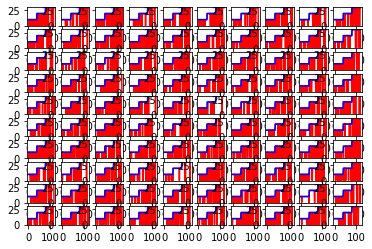

In [16]:
# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()